In [279]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [280]:
N = 128
D_x = 0.2

x_max = N * D_x
y_max = N * D_y
sigma = 0.1 * x_max

In [281]:
def generate_starting_rho():
    x = np.arange(0, N+1, dtype=float) * D_x
    y = np.arange(0, N+1, dtype=float) * D_x

    Y, X = np.meshgrid(y, x, indexing='ij')

    x_pos_center = 0.35 * x_max
    x_neg_center = 0.65 * x_max
    y_center = 0.5 * y_max

    rho_plus = np.exp(
        -((X - x_pos_center)**2 + (Y - y_center)**2) / sigma**2
    )

    rho_minus = np.exp(
        -((X - x_neg_center)**2 + (Y - y_center)**2) / sigma**2
    )

    rho = rho_plus - rho_minus

    return rho


In [282]:
@jit(nopython=True)
def calculate_rho_tilde(rho: np.ndarray, k: int) -> np.ndarray:
    rho_tilde = np.zeros((N + 1, N + 1))
    half_k = k // 2

    c_coeffs = np.ones(k + 1)
    c_coeffs[0] = 0.5
    c_coeffs[-1] = 0.5
    w = np.sum(c_coeffs)**2

    for i in range(N + 1):
        for j in range(N + 1):
            if i < half_k or i > N - half_k or j < half_k or j > N - half_k:
                rho_tilde[i, j] = rho[i, j]
                continue

            weighted_sum = 0.0
            for alpha in range(k+1):
                for beta in range(k+1):
                    # weighted_sum += c_coeffs[alpha] * c_coeffs[beta] * rho[i+alpha-half_k, j+beta-half_k]
                    weighted_sum += c_coeffs[alpha] * c_coeffs[beta] * rho[i+alpha, j+beta]

            rho_tilde[i, j] = weighted_sum / w

    return rho_tilde

@jit(nopython=True)
def calculate_S(V: np.ndarray, rho_tilde: np.ndarray, k: int) -> float:
    S_sum = 0.0

    area_factor_half = (k * D_x)**2 / 2.0
    denom_factor = 1.0 / (2.0 * k * D_x)

    for i in range(0, N, k):
        for j in range(0, N, k):
            dV_dx_avg = (
                (V[i + k, j] - V[i, j]) +
                (V[i + k, j + k] - V[i, j + k])
            ) * denom_factor

            dV_dy_avg = (
                (V[i, j + k] - V[i, j]) +
                (V[i + k, j + k] - V[i + k, j])
            ) * denom_factor

            energy_field_squared = dV_dx_avg**2 + dV_dy_avg**2

            interaction_term = -rho_tilde[i, j] * V[i, j]

            S_sum += (energy_field_squared + interaction_term)

    S_sum *= area_factor_half

    return S_sum

In [283]:
@jit(nopython=True)
def numba_iter(V: np.ndarray, rho_tilde: np.ndarray, k: int):
    rho_mult = (k * D_x) ** 2

    for y in range(k, N, k):
        for x in range(k, N, k):
            V_neigh = (
                V[y-k, x] +
                V[y+k, x] +
                V[y, x-k] +
                V[y, x+k]
            )

            V[y, x] = 0.25 * (V_neigh + rho_mult*rho_tilde[y, x])

def relax_local(V: np.ndarray, k: int):
    epsilon = 1e-08

    rho_tilde = calculate_rho_tilde(rho, k)
    prev_S = calculate_S(V, rho_tilde, k)

    all_Ss = []

    MAX_ITER = 2_000
    for i in range(MAX_ITER):
        numba_iter(V, rho_tilde, k)

        S = calculate_S(V, rho_tilde, k)
        all_Ss.append(S)

        if abs(S - prev_S) < epsilon * abs(prev_S):
            break

        prev_S = S

    return V, all_Ss

@jit(nopython=True)
def interpolate_grid(V: np.ndarray, k: int) -> np.ndarray:
    step = k // 2

    for i in range(0, N, k):
        for j in range(0, N, k):
            V[i+step, j+step] = 0.25 * (V[i, j] + V[i+k, j] + V[i, j+k] + V[i+k, j+k])

    for i in range(0, N + 1, k):
        for j in range(0, N, k):
            V[i, j+step] = 0.5 * (V[i, j] + V[i, j+k])

    for i in range(0, N, k):
        for j in range(0, N + 1, k):
            V[i+step, j] = 0.5 * (V[i, j] + V[i+k, j])

    return V

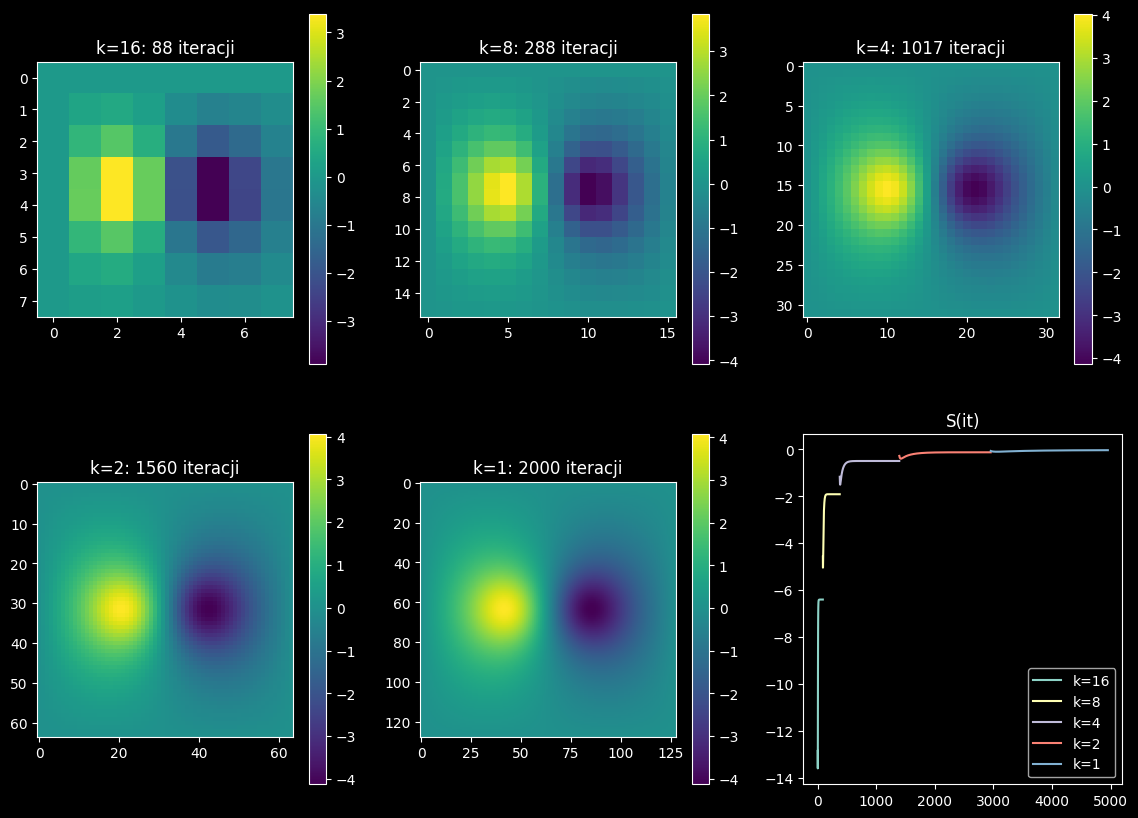

In [284]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
axs = axs.flatten()

rho = generate_starting_rho()
V = np.zeros((N+1, N+1))

it_offset: int = 1
for idx, k in enumerate([16, 8, 4, 2, 1]):
    V, Ss = relax_local(V, k)
    it = len(Ss)

    y, x = np.meshgrid(np.arange(0, N, k), np.arange(0, N, k), indexing='ij')
    V_lowres = V[y, x]

    ax = axs[idx]
    ax.set_title(f"k={k}: {it} iteracji")
    im = ax.imshow(V_lowres)
    cbar = fig.colorbar(im, ax=ax)

    ax = axs[5]
    ax.plot(np.arange(it) + it_offset, Ss, label=f"k={k}")
    it_offset += it

    if k > 1:
        V = interpolate_grid(V, k)

ax = axs[5]
ax.set_title(f"S(it)")
ax.legend()